In [1]:
import argparse
import os
import pickle
import sys

import matplotlib.pyplot as plt
import torch as T
import torch.nn.functional as NNF
import yaml
from torch.optim import Adam
from torchmetrics.detection import MeanAveragePrecision
from torchvision.ops import box_convert
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes
from tqdm import tqdm

sys.path.append('/home/volpepe/Desktop/FSOD_CenterNet/src')
from data_pipeline import DatasetsGenerator
from model import Model


def load_settings(settings_path: str):
    with open(settings_path, 'r') as f:
        return yaml.safe_load(f)

print(os.getcwd())
if os.getcwd() == '/home/volpepe/Desktop/FSOD_CenterNet/src/notebooks':
    os.chdir('/home/volpepe/Desktop/FSOD_CenterNet/src')
settings = './settings/base_training_adjusted_visualization.yaml'

config = load_settings(settings)

debug_mode = config['debug']['debug_mode_active']
device = config['device']

# Dataset generator. Only one of these has to be instantiated. It always returns
dataset_gen = DatasetsGenerator(config)

# Instantiate the model (only the base part)
model = Model(config, n_base_classes=len(dataset_gen.train_base.cats))
model = model.to(device)

# Use the dataset generator to generate the base set
dataset_base_train, dataset_base_val, dataset_base_test = dataset_gen.get_base_sets_dataloaders(
    config['training']['batch_size'], config['training']['num_workers'],
    config['training']['pin_memory'], config['training']['drop_last'], 
    shuffle=True
)

model.load_state_dict(T.load('../data/weights/base/best_model_adjusted.pt', map_location="cpu"))

cats = dataset_base_train.dataset.coco.cats
base_classes = list(cats)

/home/volpepe/Desktop/FSOD_CenterNet/src/notebooks
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=1.61s)
creating index...
index created!
Skipping instantating novel head


In [2]:
@T.no_grad()
def get_heatmap_maxima_idxs(complete_heatmaps):
    pooled_heatmaps = NNF.max_pool2d(complete_heatmaps,
                                    3,
                                    stride=1,
                                    padding=1)
    return (complete_heatmaps == pooled_heatmaps)

@T.no_grad()
def landmarks_from_idxs(regressor_pred: T.tensor,
                        complete_heatmaps: T.tensor,
                        idxs_tensor_mask: T.tensor):
    n_classes, output_width, output_height = idxs_tensor_mask.shape

    # Flattens it so we can use topk
    confidence_scores = T.masked_select(complete_heatmaps, idxs_tensor_mask)
    confidence_scores[confidence_scores < config['eval']['threshold_classification_scores']] = 0.

    num_detections = T.sum(idxs_tensor_mask).to('cpu')
    num_detections = min(config['data']['max_detections'][-1], num_detections)
    num_detections = min(T.sum(confidence_scores > 0), num_detections)

    landmarks_pred = {
        "boxes": T.zeros(num_detections,4, device=regressor_pred.device),
        "labels": T.zeros(num_detections, device=regressor_pred.device).to(T.int32),
        "scores": T.zeros(num_detections, device=regressor_pred.device)
    }

    # The i-th element in top_k_scores has the i-th highest confidence score in the image, 
    # but its index refers to its position in "confidence_scores" (which is a flattened tensor
    # tthat has as many elements as idxs_tensor_mask's true values, or peaks).
    # Instead, we will need a n_classes*output_width*output_height tensor to get indices
    top_k_scores = T.topk(confidence_scores, num_detections)
    
    # This retrieves all of the (flattened) indices (of the output image) where the classification has a peak
    flattened_idxs = T.nonzero(T.flatten(idxs_tensor_mask)).reshape(-1)
    
    # this retrieves only the top "num_detections" of them (but still, flattened)
    flattened_top_k_idxs = flattened_idxs[top_k_scores.indices]

    base_mask = T.zeros(n_classes*output_width*output_height).to(device=device)
    # Populates the mask with 1s for topk indices
    base_mask[flattened_top_k_idxs] += 1
    mask = base_mask.to(dtype=T.bool)

    top_k_mask = T.unflatten(mask, dim=0, sizes=(n_classes, output_height, output_width))
    top_k_idxs = T.nonzero(top_k_mask)

    regressor_pred_repeated = regressor_pred.repeat(n_classes,1,1,1)

    size_x = T.masked_select(regressor_pred_repeated[:,0,:,:],
                                top_k_mask)
    size_y = T.masked_select(regressor_pred_repeated[:,1,:,:],
                                top_k_mask)
    off_x = T.masked_select(regressor_pred_repeated[:,2,:,:],
                                top_k_mask)
    off_y = T.masked_select(regressor_pred_repeated[:,3,:,:],
                                top_k_mask)

    category = top_k_idxs[:,0]
    center_idx_y = top_k_idxs[:,1]
    center_idx_x = top_k_idxs[:,2]

    center_coord_x = center_idx_x+off_x
    center_coord_y = center_idx_y+off_y

    landmarks_pred['boxes'][:, 0] = center_coord_x
    landmarks_pred['boxes'][:, 1] = center_coord_y
    landmarks_pred['boxes'][:, 2] = size_x
    landmarks_pred['boxes'][:, 3] = size_y
    landmarks_pred["labels"] = category
    landmarks_pred["scores"] = confidence_scores[top_k_scores.indices]
    return landmarks_pred

def showgrid(img, orig_img, heat_gt, heat_pred, land_gt, land_pred):

    batch_size = img.shape[0]
    print()
    f, axarr = plt.subplots(6, batch_size, constrained_layout=True, figsize=(13,17))

    # (xmin, ymin, xmax, ymax)

    for b in range(batch_size):

        correct_dimensions_gt = T.concat((  land_gt[b]['boxes'][:, :2] * 4, 
                                            land_gt[b]['boxes'][:, 2:]), 
                                            axis=1)
        correct_dimensions_pred = T.concat((land_pred[b]['boxes'][:, :2] * 4, 
                                            land_pred[b]['boxes'][:, 2:]), 
                                            axis=1)

        img_to_plot = draw_bounding_boxes(
            (orig_img[b]).to(T.uint8), 
            colors='red',
            width=2,
            boxes=box_convert(
                correct_dimensions_gt, 
                in_fmt="cxcywh", 
                out_fmt="xyxy"
            )
        )
        img_to_plot = draw_bounding_boxes(
            img_to_plot, 
            colors='green',
            boxes=box_convert(
                correct_dimensions_pred, 
                in_fmt="cxcywh", 
                out_fmt="xyxy"
                )
        )
        axarr[0,b].imshow(F.to_pil_image(img_to_plot))
        axarr[0,b].set_title(f"Image {b+1}")

        print(f"Max score in heatmap: {T.max(heat_pred[b]).item():.4f}")
        heat_pred[b][:,0,0] = (T.ones_like(heat_pred[b][:,0,0])*T.max(heat_pred[b]))
        # boxes, labels = box_and_label_from_landmarks(land_gt[b], img.shape[-1])
        # print(boxes)
        img_to_plot = draw_bounding_boxes(
            (img[b]*256).to(T.uint8), 
            boxes=box_convert(
                correct_dimensions_gt, 
                in_fmt="cxcywh", 
                out_fmt="xyxy"
            )
        )
        axarr[1,b].imshow(F.to_pil_image(img_to_plot))
        axarr[1,b].set_title('Model Input')

        # boxes, labels = box_and_label_from_landmarks(land_pred[b], img.shape[-1])
        # img_to_plot = draw_bounding_boxes(
        #     (img[b]*256).to(T.uint8), 
        #     boxes=box_convert(
        #         correct_dimensions_pred, 
        #         in_fmt="cxcywh", 
        #         out_fmt="xyxy"
        #         )
        # )
        # axarr[2,b].imshow(F.to_pil_image(img_to_plot))
        
        axarr[2,b].imshow(F.to_pil_image(T.max(heat_gt[1][b], dim=0).values))
        axarr[2,b].set_title('GT Heatmap')
        axarr[3,b].imshow(F.to_pil_image(T.max(heat_pred[b], dim=0).values))
        axarr[3,b].set_title('Classwise Max (Predicted)')

        tmp_label = land_gt[b]["labels"][0]
        axarr[4,b].imshow(F.to_pil_image(heat_pred[b][tmp_label]))
        axarr[4,b].set_title('Correct Class (Predicted)')

        tmp = T.max(heat_pred[b], dim=0).values - heat_pred[b][tmp_label]
        tmp[0,0] = T.max(heat_pred[b])
        axarr[5,b].imshow(tmp)
        axarr[5,b].set_title('Classwise Max - Correct Class')

        #### EVAL ####
        n_label_gt = 0
        c_right = 0
        mean_score_right = 0
        c_wrong = 0
        mean_score_wrong = 0
        
        for label_gt in land_gt[b]["labels"]:
            n_label_gt+=1
            for label_pred, score in zip(land_pred[b]["labels"], land_pred[b]["scores"]):
                if label_gt == label_pred:
                    c_right+=1
                    mean_score_right += score.item()
                else:
                    c_wrong+=1
                    mean_score_wrong += score.item()

        c_right /= n_label_gt
        mean_score_right /= n_label_gt
        if c_right != 0:
            mean_score_right /= c_right
            
        c_wrong /= n_label_gt
        mean_score_wrong /= n_label_gt
        if c_wrong != 0:
            mean_score_wrong /= c_wrong
        print("Image ", b+1, " - Right ", c_right, " - Mean Score ", mean_score_right, 
              " - Wrong ", c_wrong, " - Mean Score ", mean_score_wrong)

        for pred_c in land_gt[b]['labels']:
            print(cats[base_classes[pred_c]])
        print('---')
        for pred_c, score_c in zip(land_pred[b]['labels'], land_pred[b]['scores']):
            print(f'score: {score_c:.4f}', '--->', cats[base_classes[pred_c]])
        print()
        print()
        ##############

    
    for b in axarr.flat:
        plt.axis('on')
        b.set_xticks([])
        b.set_yticks([])

    plt.show()

model time: 1.10 s

Max score in heatmap: 0.1235
Image  1  - Right  0.0  - Mean Score  0.0  - Wrong  0.0  - Mean Score  0.0
{'supercategory': 'Aves', 'id': 2188, 'name': 'Pandion haliaetus'}
---


Max score in heatmap: 0.2311
Image  2  - Right  0.0  - Mean Score  0.0  - Wrong  15.0  - Mean Score  0.18353552917639415
{'supercategory': 'Aves', 'id': 4733, 'name': 'Aythya affinis'}
{'supercategory': 'Aves', 'id': 4733, 'name': 'Aythya affinis'}
---
score: 0.2311 ---> {'supercategory': 'Aves', 'id': 4311, 'name': 'Fulica americana'}
score: 0.2118 ---> {'supercategory': 'Aves', 'id': 4311, 'name': 'Fulica americana'}
score: 0.2011 ---> {'supercategory': 'Aves', 'id': 3752, 'name': 'Anas platyrhynchos'}
score: 0.1961 ---> {'supercategory': 'Aves', 'id': 3752, 'name': 'Anas platyrhynchos'}
score: 0.1905 ---> {'supercategory': 'Aves', 'id': 4950, 'name': 'Podilymbus podiceps'}
score: 0.1869 ---> {'supercategory': 'Aves', 'id': 4950, 'name': 'Podilymbus podiceps'}
score: 0.1860 ---> {'supercate

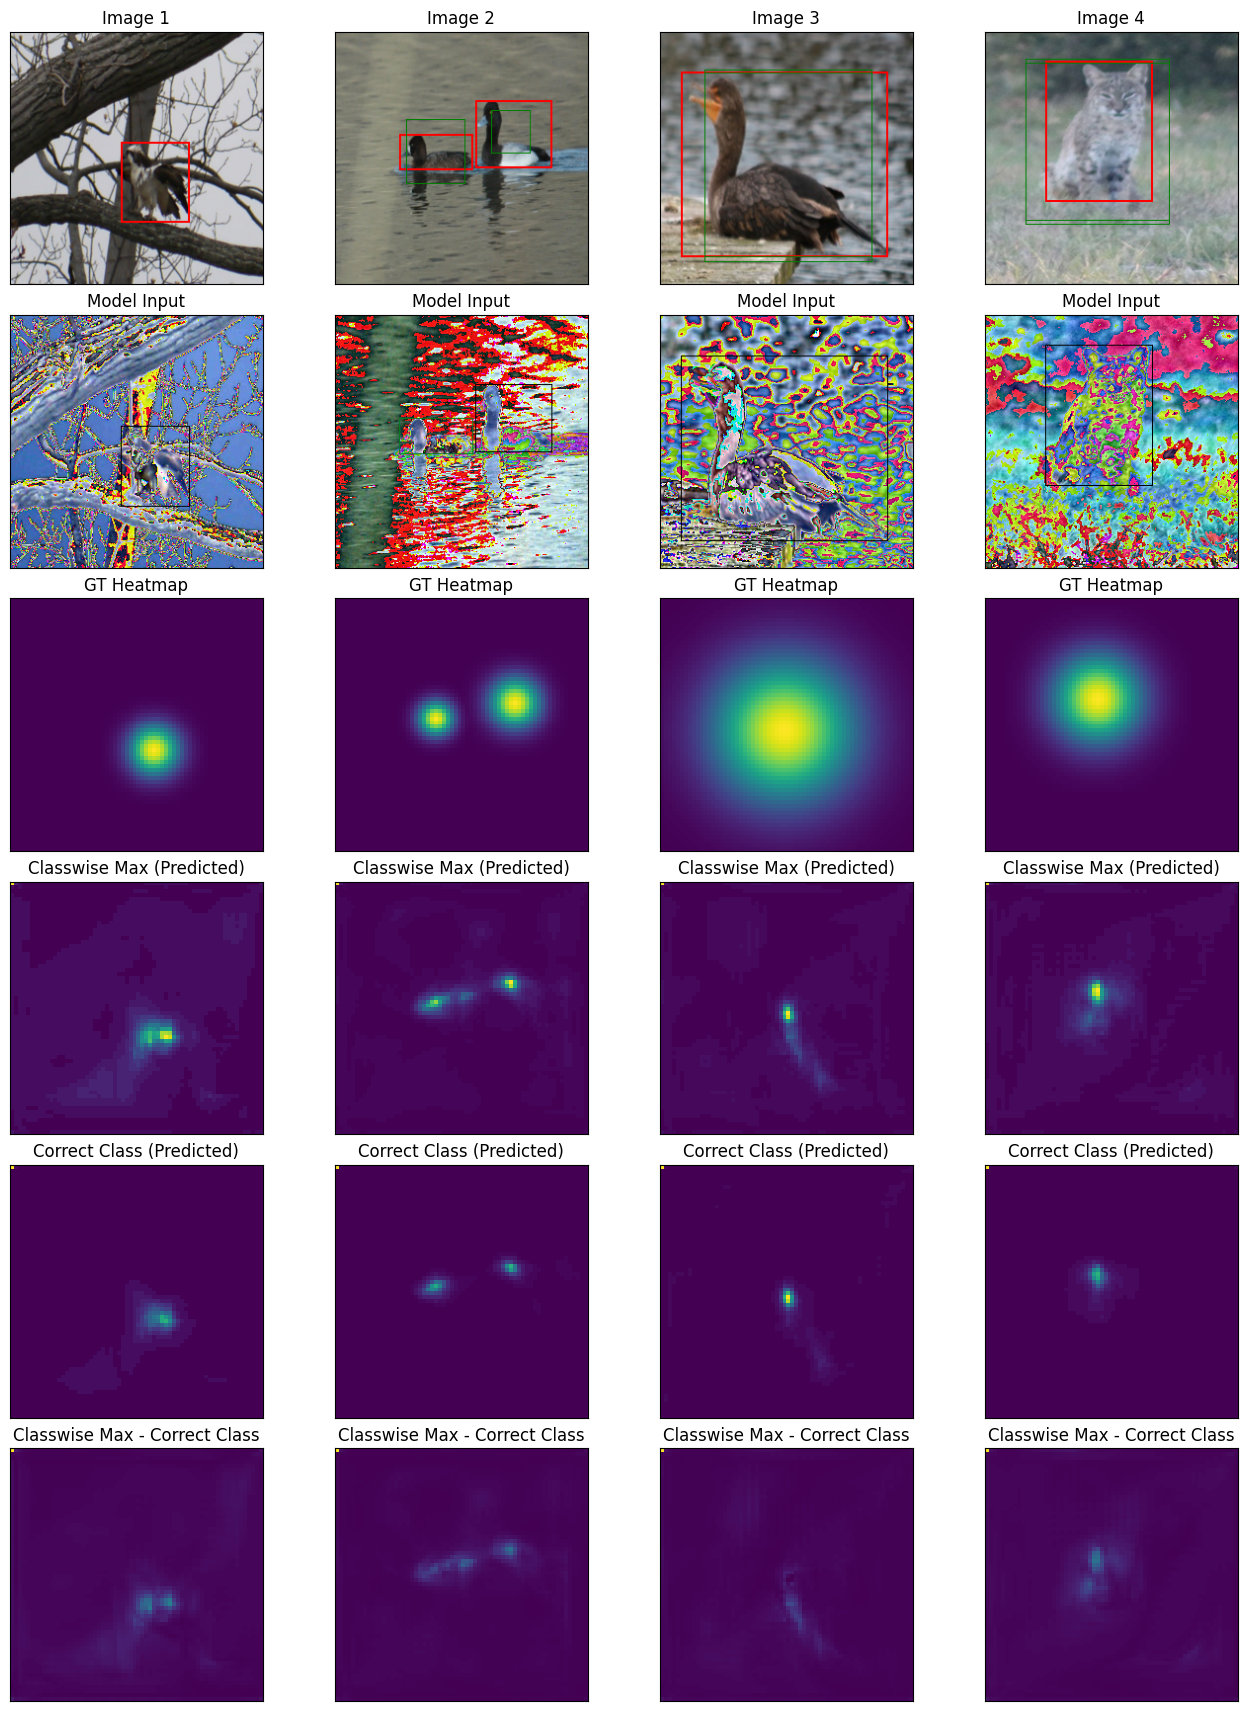

In [7]:
import copy
import time

with T.no_grad():

    for counter, (image_batch, labels_batch, original_image_batch, n_landmarks_batch, padded_landmarks) in enumerate(dataset_base_train):

        # both image and landmarks will be resized to model_input_size
        s = time.time()
        reg_pred_batch, heat_base_pred_batch, heat_novel_pred_batch = model(image_batch.to('cpu'))
        model_time = time.time() - s

        print(f"model time: {model_time:.2f} s")

        list_landmarks_pred = []
        list_landmarks_gt = []
        
        for i, (reg_pred, heat_base_pred, n_landmarks) in \
            enumerate(zip(reg_pred_batch, heat_base_pred_batch, n_landmarks_batch)):
            complete_heatmaps = heat_base_pred

            idxs_tensor = get_heatmap_maxima_idxs(complete_heatmaps)

            landmarks_pred = landmarks_from_idxs(
                reg_pred,
                complete_heatmaps,
                idxs_tensor
            )

            landmarks_gt = {
                "boxes": padded_landmarks["boxes"][i,:n_landmarks,:],
                "labels": padded_landmarks["labels"][i,:n_landmarks]
            }

            list_landmarks_pred.append(landmarks_pred)
            list_landmarks_gt.append(landmarks_gt)

        break

    showgrid(image_batch, original_image_batch, copy.copy(labels_batch), 
             copy.copy(heat_base_pred_batch), list_landmarks_gt, list_landmarks_pred)